# Hurricane Analysis

### Step 1: Call in Data

In [71]:
import xarray as xr
import polars as pl
import matplotlib.pyplot as plt
# import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
# import calendar
from shapely.geometry import LineString
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap
# taken from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/IBTrACS.ALL.v04r01.nc on 12/5/2025
filepath = "../.data/IBTrACS.ALL.v04r01 - 2025.12.05.nc"
KNOTS_TO_MPH = 1.15078

ds = xr.open_dataset(filepath)

In [39]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:           (storm: 13534, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] 39MB ...
    lat               (storm, date_time) float32 19MB ...
    lon               (storm, date_time) float32 19MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/159)
    numobs            (storm) float32 54kB ...
    sid               (storm) |S13 176kB ...
    season            (storm) float32 54kB ...
    number            (storm) int16 27kB ...
    basin             (storm, date_time) |S2 10MB ...
    subbasin          (storm, date_time) |S2 10MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 19MB ...
    reunion_gust_per  (storm, date_time) float32 19MB ...
    usa_seahgt        (storm, date_time) float32 19MB ...
    usa_searad        (storm, date_time, quadrant) float32 78MB ...
    storm_speed       (storm, date_time) float32 19MB ...
    storm_dir         (storm, date_time) float32 19MB ...
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Wed Dec  3 19:03:36 2025: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

### Step 2: Filter relevant data

Filter for just tropical cyclones in the Caribbean Sea or Gulf of Mexico

Want to pinpoint the maximum wind speed for each storm and what date that occurs at

In [72]:
ds_CS_GM = (
    ds
    .where((ds['subbasin'] == b'CS') | (ds['subbasin'] == b'GM'), drop=True)
    [['sid', 'time', 'lat', 'lon', 'usa_wind', 'usa_sshs', 'storm_speed', 'subbasin']]
)
ds_CS_GM['usa_wind'] = ds_CS_GM['usa_wind'] * KNOTS_TO_MPH
ds_CS_GM


<xarray.Dataset> Size: 9MB
Dimensions:      (storm: 1108, date_time: 178)
Coordinates:
    time         (storm, date_time) datetime64[ns] 2MB 1851-06-23T12:00:00.00...
    lat          (storm, date_time) float32 789kB 26.1 26.2 26.3 ... nan nan nan
    lon          (storm, date_time) float32 789kB -90.4 -90.7 -91.0 ... nan nan
Dimensions without coordinates: storm, date_time
Data variables:
    sid          (storm, date_time) object 2MB b'1851175N26270' ... nan
    usa_wind     (storm, date_time) float32 789kB nan nan nan ... nan nan nan
    usa_sshs     (storm, date_time) float32 789kB -5.0 -5.0 -5.0 ... nan nan nan
    storm_speed  (storm, date_time) float32 789kB 6.0 6.0 6.0 ... nan nan nan
    subbasin     (storm, date_time) object 2MB b'GM' b'GM' b'GM' ... nan nan nan
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Wed Dec  3 19:03:36 2025: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

In [75]:
ds_CS_GM[['usa_wind']].max()

<xarray.Dataset> Size: 4B
Dimensions:   ()
Data variables:
    usa_wind  float32 4B 189.9

In [64]:
ds_CS_GM_pl = (
    pl.DataFrame(ds_CS_GM.to_dataframe().reset_index())
)
ds_CS_GM_pl

storm,date_time,sid,time,lat,lon,usa_wind,usa_sshs,storm_speed,subbasin
i64,i64,binary,datetime[ns],f32,f32,f32,f32,f32,binary
0,0,"b""1851175N26270""",1851-06-23 12:00:00.000040224,26.1,-90.400002,null,-5.0,6.0,"b""GM"""
0,1,"b""1851175N26270""",1851-06-23 15:00:00.000040224,26.200001,-90.699997,null,-5.0,6.0,"b""GM"""
0,2,"b""1851175N26270""",1851-06-23 18:00:00.000040224,26.299999,-91.0,null,-5.0,6.0,"b""GM"""
0,3,"b""1851175N26270""",1851-06-23 21:00:00.000040224,26.4,-91.300003,null,-5.0,6.0,"b""GM"""
0,4,"b""1851175N26270""",1851-06-24 00:00:00.000040224,26.5,-91.599998,null,-5.0,6.0,"b""GM"""
…,…,…,…,…,…,…,…,…,…
1107,173,null,null,null,null,null,null,null,null
1107,174,null,null,null,null,null,null,null,null
1107,175,null,null,null,null,null,null,null,null


### Step 3: Select Max Speed Point for Each Storm

In [77]:
ds_CS_GM_max = (
    ds_CS_GM_pl
    .filter(pl.col('usa_wind').is_not_null())
    .sort(['storm', 'usa_wind'], descending=[False, True]) 
    .unique(subset=['storm'], keep='first') 
    .select('storm', 'date_time', 'lon', 'lat', 'usa_wind', 'usa_sshs', 'time', 'sid', 'storm_speed', 'subbasin')
    .with_columns(
        pl.col('time').dt.year().alias('year'),
        pl.col('time').dt.month().alias('month')
    )
)
ds_CS_GM_max.sort('usa_wind')

storm,date_time,lon,lat,usa_wind,usa_sshs,time,sid,storm_speed,subbasin,year,month
i64,i64,f32,f32,f32,f32,datetime[ns],binary,f32,binary,i32,i8
815,0,-84.0,30.1,11.507799,-2.0,1986-08-13 12:00:00.000040448,"b""1986226N30276""",7.0,"b""GM""",1986,8
1104,0,-83.0,26.299999,17.2617,-3.0,2025-07-03 06:00:00.000039936,"b""2025184N26277""",13.0,"b""GM""",2025,7
796,46,-61.799999,18.299999,23.015598,-1.0,1983-08-02 06:00:00.000040448,"b""1983209N12333""",14.0,"b""CS""",1983,8
819,18,-62.200001,18.5,23.015598,-1.0,1987-08-15 06:00:00.000040448,"b""1987225N13313""",17.0,"b""CS""",1987,8
847,10,-82.400002,26.700001,23.015598,-3.0,1991-06-30 18:00:00.000040448,"b""1991181N26282""",7.0,"b""GM""",1991,6
…,…,…,…,…,…,…,…,…,…,…,…
477,40,-80.900002,24.9,184.124786,5.0,1935-09-03 03:00:00.000040448,"b""1935241N23291""",6.0,"b""GM""",1935,9
831,43,-83.800003,19.700001,184.124786,5.0,1988-09-14 00:00:00.000040448,"b""1988253N12306""",13.0,"b""CS""",1988,9
950,30,-82.800003,17.299999,184.124786,5.0,2005-10-19 12:00:00.000039936,"b""2005289N18282""",6.0,"b""CS""",2005,10


### Step 4: Transform Data

Look at graphs to determine if data seems reasonable

Text(0.5, 1.0, 'Max Wind for Each Storm Over Time')

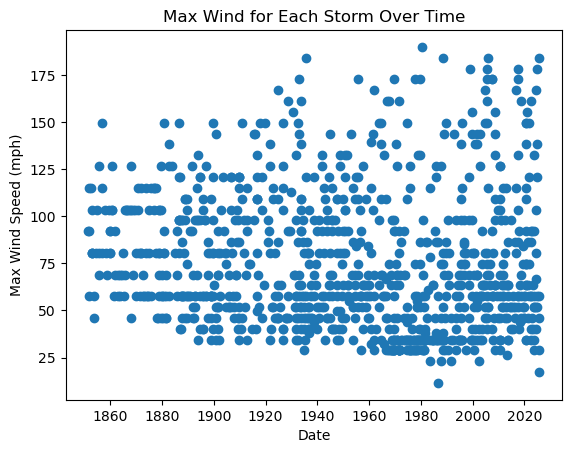

In [70]:
plt.scatter(ds_CS_GM_max['time'], ds_CS_GM_max['usa_wind'])
plt.xlabel('Date')
plt.ylabel('Max Wind Speed (mph)')
plt.title('Max Wind for Each Storm Over Time')

Text(0.5, 1.0, 'Max Wind for Each Storm Over Month')

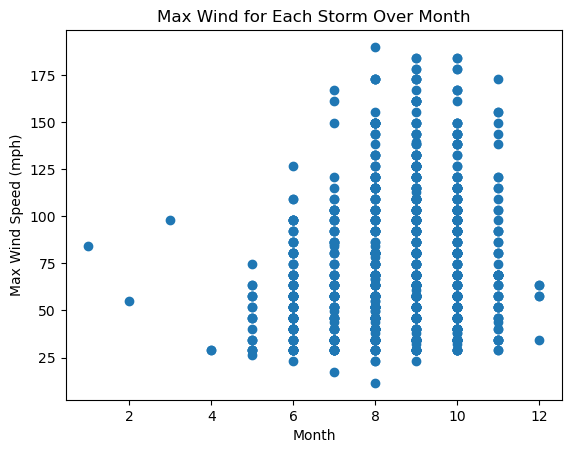

In [79]:
plt.scatter(ds_CS_GM_max['month'], ds_CS_GM_max['usa_wind'])
plt.xlabel('Month')
plt.ylabel('Max Wind Speed (mph)')
plt.title('Max Wind for Each Storm Over Month')

### Step 5: Export Data

In [78]:
ds_CS_GM_max.write_parquet('../.data/cyclone_max_wind.parquet')